In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import os
import seaborn as sns

In [21]:
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import ema_logging
from ema_workbench import MultiprocessingEvaluator

from ema_workbench.analysis import parcoords

In [22]:
ema_logging.log_to_stderr(ema_logging.INFO)

"""
    Parameters
    ----------
    problem_formulation_id : int {0, ..., 6}
                             problem formulations differ with respect to the objectives
                             0: Total cost, and casualties
                             1: Expected damages, costs, and casualties
                             2: expected damages, dike investment costs, rfr costs, evacuation cost, and casualties
                             3: costs and casualties disaggregated over dike rings, and room for the river and evacuation costs
                             4: Expected damages, dike investment cost and casualties disaggregated over dike rings and room for the river and evacuation costs
                             5: disaggregate over time and space
                             6: Same as 3 but only aggregated for Gelderland, NOTE Expected annual damage only represents Gelderland
                             7: Also added total rfr and total dike_investment

    """
problem_formulation = 7  # Change this to the desired problem formulation ID
dike_model, planning_steps = get_model_for_problem_formulation(problem_formulation)

In [23]:
for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)


CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [24]:
from ema_workbench import ScalarOutcome, Scenario

# List of outcomes you want to optimize
# objectives = ['Expected Annual Damage', 'Expected Number of Deaths']

# # Loop over all outcomes
# for outcome in dike_model.outcomes:
#     if outcome.name in objectives:
#         outcome.kind = ScalarOutcome.MINIMIZE 
#     else:
#         outcome.kind = ScalarOutcome.INFO  # neutral, will be ignored in optimization


for outcome in dike_model.outcomes:
    print(f"{outcome.name}: kind={outcome.kind}")

reference_scenario = Scenario('Reference Scenario', **dict({
    'discount rate 0': 2.5,
    'discount rate 1': 2.5,
    'discount rate 2': 2.5,
    'A.0_ID flood wave shape': 4,
    'A.1_Bmax': 175,
    'A.2_Bmax': 175,
    'A.3_Bmax': 175,
    'A.4_Bmax': 175,
    'A.5_Bmax': 175,
    'A.1_pfail': 0.5,
    'A.2_pfail': 0.5,
    'A.3_pfail': 0.5,
    'A.4_pfail': 0.5,
    'A.5_pfail': 0.5,
    'A.1_Brate': 1.5,
    'A.2_Brate': 1.5,
    'A.3_Brate': 1.5,
    'A.4_Brate': 1.5,
    'A.5_Brate': 1.5
}))



Expected Annual Damage: kind=-1
Dike Investment Costs: kind=-1
RfR Total Costs: kind=-1
Evacuation Costs: kind=-1
Expected Number of Deaths: kind=-1


In [25]:
from ema_workbench.em_framework.optimization import EpsilonProgress
convergence_metrics = [EpsilonProgress()]
# Epsilon values are the ones close to the average value of the outcome, based on exploration and problem formulation.ipynb
#epsilons = [5e7,5e7,5e8,4e3,4]
epsilons = [1e6,1e5,1e8, 0.3,0.3]
with MultiprocessingEvaluator(dike_model) as evaluator:
    results1, convergence = evaluator.optimize(nfe=20000, searchover='levers',  epsilons=epsilons, reference=reference_scenario,convergence=convergence_metrics)

[MainProcess/INFO] pool started with 16 workers
20032it [09:31, 35.04it/s]                                                     
[MainProcess/INFO] optimization completed, found 21 solutions
[MainProcess/INFO] terminating pool


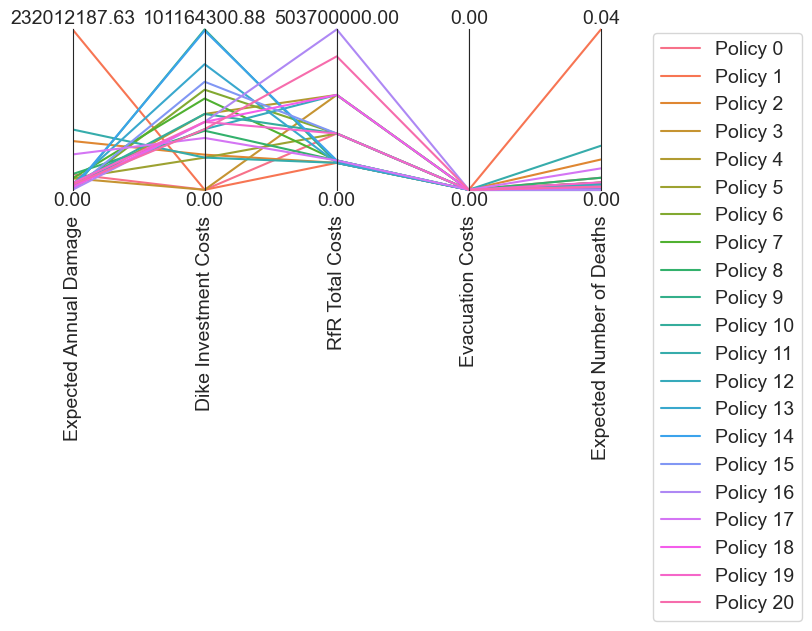

In [26]:
data = results1.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0] = 0  # optional, set axes baseline

paraxes = parcoords.ParallelAxes(limits)

# Generate a color palette with as many colors as there are policies
colors = sns.color_palette("husl", len(data))

# Plot each policy with its own color and label
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, color=colors[i], label=f"Policy {index}")

# Show legend to map color to policy
paraxes.legend()

plt.show()

In [27]:
results1

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.1_DikeIncrease 2,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Total Costs,Evacuation Costs,Expected Number of Deaths
0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.269673e+07,0.000000e+00,176700000.0,0,0.003094
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.320122e+08,0.000000e+00,84600000.0,0,0.041179
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,7.050378e+07,2.216782e+07,84600000.0,0,0.007783
3,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.655465e+07,0.000000e+00,297900000.0,0,0.001826
4,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,2.425434e+06,4.784270e+07,297900000.0,0,0.000500
5,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.664140e+07,2.029929e+07,176700000.0,0,0.001845
6,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,3,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,1.319850e+06,6.311770e+07,176700000.0,0,0.000149
7,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,3,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.664140e+07,5.755449e+07,92100000.0,0,0.001845
8,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.269673e+07,3.725520e+07,92100000.0,0,0.003094
9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,5,0,0,0,1,0,0,0,0,0.000000e+00,1.011643e+08,84600000.0,0,0.000000


In [28]:
# Get the lever names from your model
lever_names = [lever.name for lever in dike_model.levers]

# Extract only the levers (i.e., policies) into a new DataFrame
policies_df = results1[lever_names]

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
policies_df

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.1_DikeIncrease 2,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,3,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,3,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,5,0,0,0,1,0,0,0,0


In [31]:
outcomes_df = results1[[o.name for o in dike_model.outcomes]]
outcomes_df

,Expected Annual Damage,Dike Investment Costs,RfR Total Costs,Evacuation Costs,Expected Number of Deaths
0,2.269673e+07,0.000000e+00,176700000.0,0,0.003094
1,2.320122e+08,0.000000e+00,84600000.0,0,0.041179
2,7.050378e+07,2.216782e+07,84600000.0,0,0.007783
3,1.655465e+07,0.000000e+00,297900000.0,0,0.001826
4,2.425434e+06,4.784270e+07,297900000.0,0,0.000500
5,1.664140e+07,2.029929e+07,176700000.0,0,0.001845
6,1.319850e+06,6.311770e+07,176700000.0,0,0.000149
7,1.664140e+07,5.755449e+07,92100000.0,0,0.001845
8,2.269673e+07,3.725520e+07,92100000.0,0,0.003094
9,0.000000e+00,1.011643e+08,84600000.0,0,0.000000


In [29]:
display(convergence_metrics)

<function matplotlib.pyplot.show(close=None, block=None)>

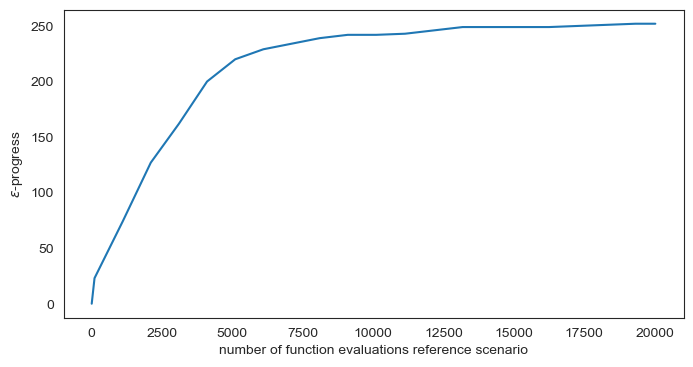

In [30]:
fig, ax = plt.subplots(ncols=1, sharex=True, figsize=(8,4))
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('number of function evaluations reference scenario')
plt.show